<a href="https://colab.research.google.com/github/GiovaniValdrighi/inferencia_causal/blob/master/scm_counterfactual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.
     |████████████████████████████████| 491kB 4.8MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import numpy as np
import torch
from vae_build import VAE, ind_from_att, label_from_dummy, dummy_from_label
import pyro
import matplotlib.pyplot as plt
from pyro.distributions import OneHotCategorical, RelaxedOneHotCategorical, Normal, Uniform, constraints, Categorical
from torch import tensor

In [5]:
dataset_zip = np.load('/content/gdrive/My Drive/autoencoder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle = True, encoding = 'bytes')
print('Keys in the dataset:', dataset_zip.files)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
latents_sizes = dataset_zip['metadata'][()][b'latents_sizes']
latents_names = dataset_zip['metadata'][()][b'latents_names']

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


In [6]:
pyro.enable_validation(True)
pyro.clear_param_store()
#the training routine
use_CUDA = False
vae = VAE(latents_sizes, latents_names, use_CUDA = use_CUDA)
vae.load_state_dict(torch.load('/content/gdrive/My Drive/trained_movel_epoch_24.save'))

<All keys matched successfully>

#Importance Sampling 
Estou utilizando o método de Importance Sampling para realizar o cálculo de contra factuais no modelo.

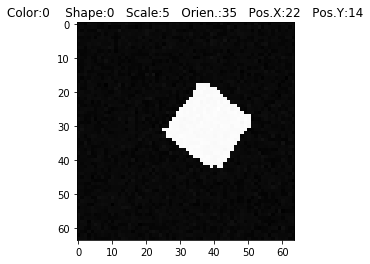

In [76]:
class SCM_model1():
  def __init__(self, vae):
    self.vae = vae
    dist = OneHotCategorical
    self.init_noise = {'color': dist(tensor([1.])),
                       'shape': dist(tensor([0.3, 0.4, 0.3])),
                       'scale': dist(tensor([1/6]).repeat(6)),
                       'orien': dist(tensor([1/40]).repeat(40)),
                       'posX': dist(tensor([1/32]).repeat(32)),
                       'posY': dist(tensor([1/32]).repeat(32)),
                       'latent': Normal(torch.zeros(200), torch.ones(200)),
                       'img': Uniform(torch.zeros(4096), torch.ones(4096))}
    
    #functions for the model
    def f_gumbel(N):
      return N
    
    def f_posX(N, scale):
      if 31 <= int(3*scale.max(0)[1] + N.max(0)[1]):
        return torch.nn.functional.one_hot(torch.tensor([31]), 32).to(torch.float32).reshape([32])
      else:
        return torch.nn.functional.one_hot(3*scale.max(0)[1] + N.max(0)[1], 32).to(torch.float32).reshape([32])

    def f_shape(N, scale):
      if scale.max(0)[1] == 5 or scale.max(0)[1] == 4:
        return torch.nn.functional.one_hot(tensor(0), 3).to(torch.float32).reshape([3])
      else:
        return N

    def f_latent(N_latent, color, shape, scale, orien, posX, posY):
      ind = ind_from_att(color.max(0)[1], shape.max(0)[1], scale.max(0)[1], orien.max(0)[1], posX.max(0)[1], posY.max(0)[1])
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      mu, sigma = vae.encoder.forward(torch.tensor(imgs[ind]).reshape(4096).to(torch.float32), label)
      return N_latent * sigma + mu

    def f_image(N_img, latent, color, shape, scale, orien, posX, posY):
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      img_decode = vae.decoder.forward(latent, label)
      return (N_img > img_decode).to(torch.float)

 
    def model(noise = self.init_noise):

      #Noise variables
      N_color = pyro.sample('N_color', noise['color'])
      N_shape = pyro.sample('N_shape', noise['shape'])
      N_scale = pyro.sample('N_scale', noise['scale'])
      N_orien = pyro.sample('N_orien', noise['orien'])
      N_posX = pyro.sample('N_posX', noise['posX'])
      N_posY = pyro.sample('N_posY', noise['posY'])
      N_latent = pyro.sample('N_latent', noise['latent'].to_event(1))
      N_img = pyro.sample('N_img', noise['img'].to_event(1))

      #variables
      scale = pyro.sample('scale', Normal(f_gumbel(N_scale), torch.tensor([0.01])).to_event(1))
      color = pyro.sample('color', Normal(f_gumbel(N_color), torch.tensor([0.01])).to_event(1))
      shape = pyro.sample('shape', Normal(f_shape(N_shape, scale), torch.tensor([0.01])).to_event(1))
      orien = pyro.sample('orien', Normal(f_gumbel(N_orien), torch.tensor([0.01])).to_event(1))
      posX = pyro.sample('posX', Normal(f_posX(N_posX, scale), torch.tensor([0.01])).to_event(1))
      posY = pyro.sample('posY', Normal(f_gumbel(N_posY), torch.tensor([0.01])).to_event(1))

      #variables
      latent = pyro.sample('latent', Normal(f_latent(N_latent, color, shape, scale, orien, posX, posY), torch.tensor([0.01])).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, color, shape, scale, orien, posX, posY), torch.tensor([0.01])).to_event(1))

      return torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1)), latent, img
    
    def guide(noise = self.init_noise):
      
      #params
      cat_val =  {'color': 1, 'shape': 3, 'scale': 6, 'orien': 40, 'posX': 32, 'posY': 32}
      probs = {key : pyro.param('prob_'+key, tensor(1/value).repeat(value), constraint = constraints.positive) for key, value in cat_val.items()}
      mu_latent = pyro.param('mu_latent', torch.ones(200)*0.5)
      sigma_latent = pyro.param('sigma_latent', torch.ones(200)*0.2, constraint = constraints.positive)
      low_img = pyro.param('low_img', torch.ones(4096)*0.5, constraint = constraints.interval(0., 1.))
      high_img = pyro.param('high_img', torch.ones(4096)*0.02, constraint = constraints.interval(0., 1.))
      
      #noise variables
      N_color = pyro.sample('N_color', OneHotCategorical(probs['color']))
      N_shape = pyro.sample('N_shape', OneHotCategorical(probs['shape']))
      N_scale = pyro.sample('N_scale', OneHotCategorical(probs['scale']))
      N_orien = pyro.sample('N_orien', OneHotCategorical(probs['orien']))
      N_posX = pyro.sample('N_posX', OneHotCategorical(probs['posX']))
      N_posY = pyro.sample('N_posY', OneHotCategorical(probs['posY']))
      N_latent = pyro.sample('N_latent', Normal(mu_latent, sigma_latent).to_event(1))
      N_img = pyro.sample('N_img', Normal(low_img, high_img).to_event(1))
      #print(sum(N_img > 1))
      #print(sum(N_img < 0))
      #variables
      color = pyro.sample('color', Normal(f_gumbel(N_color), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      shape = pyro.sample('shape', Normal(f_gumbel(N_shape), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      scale = pyro.sample('scale', Normal(f_gumbel(N_scale), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      orien = pyro.sample('orien', Normal(f_gumbel(N_orien), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      posX = pyro.sample('posX', Normal(f_gumbel(N_posX), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      posY = pyro.sample('posY', Normal(f_gumbel(N_posY), tensor(0.01)).to_event(1), infer = {'is_auxiliary' : True})
      latent = pyro.sample('latent', Normal(f_latent(N_latent, color, shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, color, shape, scale, orien, posX, posY), tensor(0.01)).to_event(1))

      return 
    
    
    def condition(obs_data, n_samples):
      obsModel = pyro.condition(model, data = obs_data)
      posterior = pyro.infer.Importance(obsModel, guide, num_samples = n_samples).run(self.init_noise)
      updated_noise = {'color' : pyro.infer.EmpiricalMarginal(posterior, sites = 'N_color'),
                       'shape': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_shape'),
                       'scale': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_scale'),
                       'orien': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_orien'),
                       'posX': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_posX'),
                       'posY': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_posY'),
                       'latent': Normal(torch.zeros(200), torch.ones(200)),
                       'img': Uniform(torch.zeros(4096), torch.ones(4096))}
      condition_posterior = pyro.infer.Importance(obsModel, num_samples = 1000).run(scm.init_noise)
      marginal_condition = pyro.infer.EmpiricalMarginal(condition_posterior, sites = 'img')
      img_condition = marginal_condition.mean
      text = 'P(img|'
      for key, value in obs_data.items():
        text += key + ' = ' + str(int(value.max(0)[1])) + ', '
      text+= ')'
      plt.title(text)
      plt.imshow(img_condition.detach().numpy().reshape(64, 64), cmap = 'Greys')
      plt.show()

    def counterfactual(obs_data, int_data, n_samples):
      obsModel = pyro.condition(model, data = obs_data)
      intModel = pyro.do(model, data = int_data)
      posterior = pyro.infer.Importance(obsModel, guide, num_samples = n_samples).run(self.init_noise)
      updated_noise = {'color' : pyro.infer.EmpiricalMarginal(posterior, sites = 'N_color'),
                       'shape': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_shape'),
                       'scale': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_scale'),
                       'orien': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_orien'),
                       'posX': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_posX'),
                       'posY': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_posY'),
                       'latent': Normal(torch.zeros(200), torch.ones(200)),
                       'img': Uniform(torch.zeros(4096), torch.ones(4096))}
      counterfactual_posterior = pyro.infer.Importance(intModel, num_samples = n_samples).run(scm.init_noise)
      marginal_condition = pyro.infer.EmpiricalMarginal(condition_posterior, sites = 'img')
      img_condition = marginal_condition.mean
      text = 'P(img|'
      for key, value in obs_data.items():
        text += key + ' = ' + str(int(value.max(0)[1])) + ', '
      text+= ')'
      plt.title(text)
      plt.imshow(img_condition.detach().numpy().reshape(64, 64), cmap = 'Greys')
      plt.show()

    def viz_model():
      label, _, img = model()
      label = label_from_dummy(label)
      plt.imshow(img.detach().numpy().reshape(64, 64), cmap = 'Greys')
      text = 'Color:0    Shape:'+str(int(label[1])) + '   Scale:' + str(int(label[2])) + '   Orien.:' + str(int(label[3])) + '   Pos.X:' + str(int(label[4])) + '   Pos.Y:' + str(int(label[5]))
      plt.title(text)
      plt.show()

    self.model = model
    self.guide = guide
    self.viz_model = viz_model
    self.condition = condition


scm = SCM_model1(vae)
scm.viz_model()

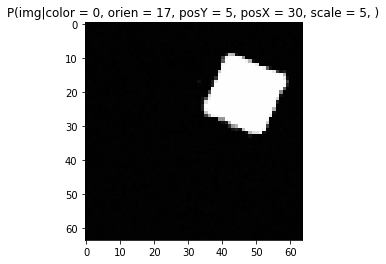

In [77]:
obs_data = {'color': tensor([1.]),
            'orien': torch.nn.functional.one_hot(tensor(17), 40).to(torch.float32),
            'posY': torch.nn.functional.one_hot(tensor(5), 32).to(torch.float32),
            'posX': torch.nn.functional.one_hot(tensor(30), 32).to(torch.float32),
            'scale': tensor([0., 0., 0., 0., 0., 1.])}
scm.condition(obs_data, 1000)

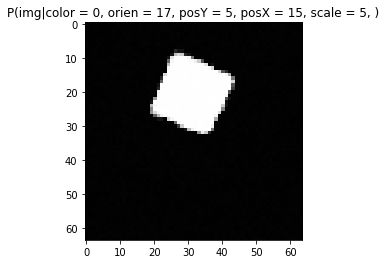

In [78]:
obs_data = {'color': tensor([1.]),
            'orien': torch.nn.functional.one_hot(tensor(17), 40).to(torch.float32),
            'posY': torch.nn.functional.one_hot(tensor(5), 32).to(torch.float32),
            'posX': torch.nn.functional.one_hot(tensor(15), 32).to(torch.float32),
            'scale': tensor([0., 0., 0., 0., 0., 1.])}
scm.condition(obs_data, 1000)

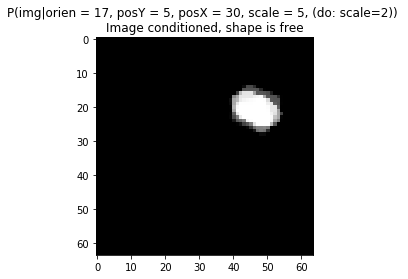

In [79]:
obs_data = {'color': tensor([1.]),
            'orien': torch.nn.functional.one_hot(tensor(17), 40).to(torch.float32),
            'posY': torch.nn.functional.one_hot(tensor(5), 32).to(torch.float32),
            'posX': torch.nn.functional.one_hot(tensor(30), 32).to(torch.float32),
            'scale': tensor([0., 0., 0., 0., 0., 1.])}
int_data = obs_data.copy()
int_data['scale'] = torch.nn.functional.one_hot(tensor(1), 6).to(torch.float32)
obsModel = pyro.condition(scm.model, data = obs_data)
intModel = pyro.do(scm.model, data = int_data)
posterior = pyro.infer.Importance(obsModel,  num_samples = 1000).run(scm.init_noise)
updated_noise = {'color' : pyro.infer.EmpiricalMarginal(posterior, sites = 'N_color'),
                 'shape': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_shape'),
                 'scale': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_scale'),
                 'orien': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_orien'),
                 'posX': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_posX'),
                 'posY': pyro.infer.EmpiricalMarginal(posterior, sites = 'N_posY'),
                 'latent': Normal(torch.zeros(200), torch.ones(200)),
                 'img': Uniform(torch.zeros(4096), torch.ones(4096))}
img_test = pyro.infer.EmpiricalMarginal(posterior, sites = 'img')
counterfactual_posterior = pyro.infer.Importance(intModel, num_samples = 1000).run(updated_noise)
marginal_counterfactual = pyro.infer.EmpiricalMarginal(counterfactual_posterior, sites = 'img')
img_counterfactual = marginal_counterfactual.mean
plt.title('P(img|orien = 17, posY = 5, posX = 30, scale = 5, (do: scale=2)) \nImage conditioned, shape is free')
plt.imshow(img_counterfactual.detach().numpy().reshape(64, 64), cmap = 'Greys')
plt.show()